In [1]:
%cd ../

/home/hoanghu/projects/Food-Waste-Optimization


In [2]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from darts.models import RandomForest
from darts import TimeSeries
from darts import metrics

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [4]:
path_root_trained_model = Path("trained_models")
path_dir_processed = Path("experiments_hoangle/processed")

path_fact = path_dir_processed / "fact.csv"
path_metrics = path_dir_processed / "metrics.csv"

# Read dataset

In [5]:
raw = pd.read_csv(path_fact, header=0, parse_dates=['date'])

raw.head(5)

,date,restaurant,num_fish,num_chicken,num_vegetarian,num_meat,num_NotMapped,num_vegan,num_customer_in,num_customer_out,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0,NaN,NaN,272.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0,NaN,NaN,327.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0,NaN,NaN,351.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0,NaN,NaN,437.0,10.00,3.3,8.5,0.0
4,2023-01-06,Chemicum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Start experiments

In [6]:
RESTAURANTS = raw['restaurant'].unique()
WASTE_TYPES = [
    'amnt_waste_customer',
    # 'amnt_waste_coffee',
    'amnt_waste_kitchen',
    # 'amnt_waste_hall'
]


# This cutoff date is used for all 3 forecasting models of 3 corresponding restaurants
# to ensure the datetime of predicted series among 3 restaurants are the same
DATE_START = '2023-01-09'
DATE_END = '2024-06-11'


# This EPS is added to series to avoid 0s
EPS = 1e-4

# This is used for both training (output_chunk_length) and backtesting/predicting (forecast_horizon)
FORECAST_HORIZON = 1

## 1. Build data

In [7]:
cols_cov = [
    'num_fish',
    'num_chicken',
    'num_vegetarian',
    'num_meat',
    # 'num_NotMapped',
    'num_vegan',
    # 'num_customer_in',
    # 'num_rcpts'
]


freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

df_tgt = pd.DataFrame({'date': date_range})
df_cov = pd.DataFrame({'date': date_range})

for restaurant in RESTAURANTS:
    # Create covariates
    cov_raw = raw[raw['restaurant'] == restaurant][['date', *cols_cov]]
    cov_raw = cov_raw[~cov_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'cov_raw'
    cov = pd.DataFrame({'date': date_range})
    cov = cov.merge(cov_raw, on='date', how='left')

    # Fill nan value with 0: because they are holidays
    cov.fillna(0, inplace=True)

    # Create target
    tgt_raw = raw[raw['restaurant'] == restaurant][['date', *WASTE_TYPES]]
    tgt_raw = tgt_raw[~tgt_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'tgt_raw'
    tgt = pd.DataFrame({'date': date_range})
    tgt = tgt.merge(tgt_raw, on='date', how='left')

    # Fill nan values by 0s: because they are holiday
    tgt.fillna(0, inplace=True)


    # rename column
    tgt.rename(
        columns={
            'amnt_waste_customer': f"{restaurant}_customer",
            'amnt_waste_kitchen': f"{restaurant}_kitchen",
            # 'amnt_waste_hall': f"{restaurant}_hall",
        },
        inplace=True
    )
    cov.rename(
        columns={
            'num_fish': f"{restaurant}_fish",
            'num_chicken': f"{restaurant}_chicken",
            'num_vegetarian': f"{restaurant}_vegetarian",
            'num_meat': f"{restaurant}_meat",
            'num_vegan': f"{restaurant}_vegan",
        },
        inplace=True
    )

    # merge to main dataframe
    df_tgt = df_tgt.merge(tgt, on='date', how='left')
    df_cov = df_cov.merge(cov, on='date', how='left')

In [8]:
df_tgt.head()

,date,Chemicum_customer,Chemicum_kitchen,Physicum_customer,Physicum_kitchen,Exactum_customer,Exactum_kitchen
0,2023-01-09,7.65,4.90,0.9,5.3,1.05,5.7
1,2023-01-10,4.90,7.00,0.5,4.7,5.50,19.8
2,2023-01-11,6.00,15.00,0.6,3.0,9.30,9.3
3,2023-01-12,7.80,8.45,0.8,4.3,20.50,20.5
4,2023-01-13,10.65,10.00,0.8,5.0,3.00,18.6


In [9]:
df_cov.head()

,date,Chemicum_fish,Chemicum_chicken,Chemicum_vegetarian,Chemicum_meat,Chemicum_vegan,Physicum_fish,Physicum_chicken,Physicum_vegetarian,Physicum_meat,Physicum_vegan,Exactum_fish,Exactum_chicken,Exactum_vegetarian,Exactum_meat,Exactum_vegan
0,2023-01-09,107.0,0.0,0.0,264.0,207.0,578.0,3.0,45.5,33.3,0.0,18.2,49.0,0.0,0.0,0.0
1,2023-01-10,241.0,0.0,77.0,33.0,174.0,525.0,0.0,39.6,34.0,0.0,17.0,41.0,74.0,15.0,0.0
2,2023-01-11,87.0,286.0,49.0,41.0,164.0,627.0,16.4,32.8,29.9,0.0,14.9,71.0,14.0,0.0,0.0
3,2023-01-12,245.0,93.0,0.0,21.0,243.0,602.0,0.0,39.3,26.2,0.0,26.2,63.0,0.0,0.0,0.0
4,2023-01-13,112.0,260.0,0.0,5.0,238.0,616.0,0.0,23.2,42.9,0.0,25.0,81.0,0.0,0.0,0.0


In [10]:
cols_tgt = [
    'Chemicum_customer',
    'Chemicum_kitchen',
    # 'Chemicum_hall',
    'Physicum_customer',
    'Physicum_kitchen',
    # 'Physicum_hall',
    'Exactum_customer',
    'Exactum_kitchen',
    # 'Exactum_hall'
]
cols_cov = df_cov.columns.tolist()
cols_cov.remove('date')

series_cov = TimeSeries.from_dataframe(
    df=df_cov,
    time_col='date',
    freq=freq,
    fill_missing_dates=False,
    value_cols=cols_cov
)
series_cov = series_cov + EPS 

series_tgt = TimeSeries.from_dataframe(
    df=df_tgt,
    time_col='date',
    freq=freq,
    fill_missing_dates=False,
    value_cols=cols_tgt
)
series_tgt = series_tgt + EPS 

## 2. Build model

In [11]:
add_encoders = {
    'cyclic': {
        'future': ['dayofweek', 'day', 'month']
    },
    'datetime_attribute': {'future': ['dayofweek', 'day', 'month']},
}
model = RandomForest(
    lags={
        'Chemicum_customer': [-1, -2, -10, -11, -12,],
        'Chemicum_kitchen': 10,
        'Physicum_customer': [-1, -2, -10, -11, -12,],
        'Physicum_kitchen': 10,
        'Exactum_customer': [-1, -2, -10, -11, -12,],
        'Exactum_kitchen': 10,
    },
    lags_future_covariates=[0],
    add_encoders=add_encoders,
    output_chunk_length=FORECAST_HORIZON
)

## 3. Backtest: predict waste amount given the meal in that day

In [12]:
rmse_bt, mse_bt = model.backtest(
    series_tgt,
    future_covariates=series_cov,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse],
    metric_kwargs={'component_reduction': None},
    verbose=True,
).tolist()

print(rmse_bt)
print(mse_bt)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/358 [00:00<?, ?it/s]

[4.176222346368718, 5.277473184357545, 0.13365139664804465, 2.2252594972067037, 2.2417717877094963, 2.749755307262569]
[38.574270650279324, 48.46906998843573, 0.03761886016759777, 17.82977074622906, 13.11151122377094, 16.863093803910605]


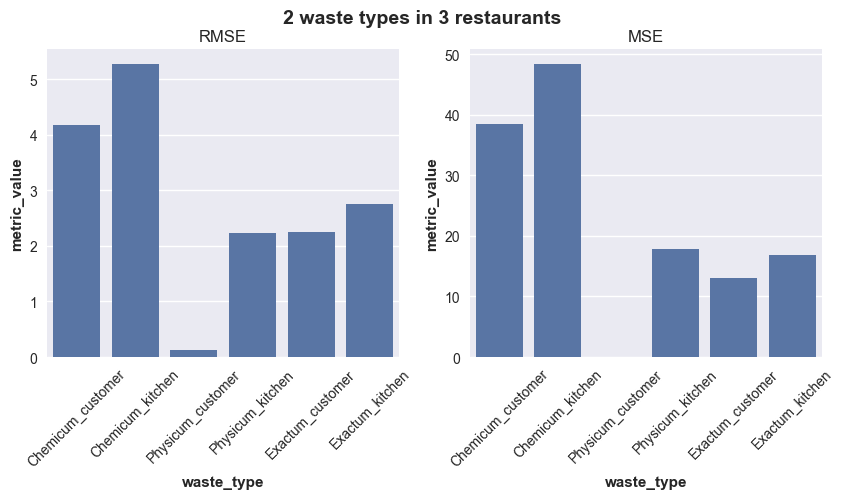

In [13]:
backtest_metrics = []

for val, component in zip(rmse_bt, series_tgt.components):
    backtest_metrics.append({
        'metric': 'RMSE',
        'waste_type': component,
        'metric_value': val
    })

for val, component in zip(mse_bt, series_tgt.components):
    backtest_metrics.append({
        'metric': 'MSE',
        'waste_type': component,
        'metric_value': val
    })

df_metrics = pd.DataFrame.from_records(backtest_metrics)

# Plot bar plot
fig = plt.figure(figsize=(10, 4))
fig.suptitle("2 waste types in 3 restaurants", fontweight='bold', fontsize=14)

for i, metric in enumerate(df_metrics['metric'].unique()):
    df_metric = df_metrics[df_metrics['metric'] == metric]

    ax = fig.add_subplot(1, 2, i+1)
    sns.barplot(df_metric, x='waste_type', y='metric_value', ax=ax)
    ax.set_title(metric.upper())
    ax.tick_params(axis='x', labelrotation = 45)

## 4. Train

In [14]:
model.fit(
    series_tgt,
    future_covariates=series_cov
)

RandomForest(lags={'Chemicum_customer': [-1, -2, -10, -11, -12], 'Chemicum_kitchen': 10, 'Physicum_customer': [-1, -2, -10, -11, -12], 'Physicum_kitchen': 10, 'Exactum_customer': [-1, -2, -10, -11, -12], 'Exactum_kitchen': 10}, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders={'cyclic': {'future': ['dayofweek', 'day', 'month']}, 'datetime_attribute': {'future': ['dayofweek', 'day', 'month']}}, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True)

## 5. Forecast

In [21]:
Chemicum_fish = 284.0001
Chemicum_chicken = 0.0001
Chemicum_vegetarian = 0.0001
Chemicum_meat = 27.0001
Chemicum_vegan = 341.0001
Physicum_fish = 799.0001
Physicum_chicken = 0.0001
Physicum_vegetarian = 31.6001
Physicum_meat = 23.2001
Physicum_vegan = 0.0001
Exactum_fish = 29.5001
Exactum_chicken = 0.0001
Exactum_vegetarian =0.0001
Exactum_meat = 0.0001
Exactum_vegan = 0.0001

In [24]:
series_cov_pred = TimeSeries.from_times_and_values(
    times=pd.DatetimeIndex(['2024-06-12']),
    values=np.array(
        [[
            Chemicum_fish,
            Chemicum_chicken,
            Chemicum_vegetarian,
            Chemicum_meat,
            Chemicum_vegan,
            Physicum_fish,
            Physicum_chicken,
            Physicum_vegetarian,
            Physicum_meat,
            Physicum_vegan,
            Exactum_fish,
            Exactum_chicken,
            Exactum_vegetarian,
            Exactum_meat,
            Exactum_vegan,
        ]],
        dtype=np.float32
    ),
    freq=freq
)
model.predict(1, future_covariates=series_cov_pred)

<TimeSeries (DataArray) (date: 1, component: 6, sample: 1)> Size: 48B
array([[[15.8136],
        [19.0816],
        [ 0.0748],
        [ 3.3529],
        [ 0.1388],
        [ 0.1193]]])
Coordinates:
  * date       (date) datetime64[ns] 8B 2024-06-12
  * component  (component) object 48B 'Chemicum_customer' ... 'Exactum_kitchen'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## 6. Save model

In [ ]:
path_model = Path("trained_models/biowaste/Jul_23_RF.pt")
model.save(path_model)

# Load models

In [25]:
path_model = Path("trained_models/biowaste/Jul_23_RF.pt")

load_model = model.load(path_model)

In [26]:
num_of_days = 3

predictions = {}

# Forecast the future
for restaurant in RESTAURANTS:
    pred = models['biowaste'][restaurant].predict(num_of_days)

    df_pred = pred.pd_dataframe().reset_index()
    df_pred['date'] = df_pred['date'].dt.strftime(r"%Y-%m-%d")

    for row in df_pred.itertuples():
        if row.date not in predictions:
            predictions[row.date] = {'date': row.date}

        predictions[row.date][restaurant] = {
            'amnt_waste_customer': row.amnt_waste_customer,
            'amnt_waste_coffee': row.amnt_waste_coffee,
            'amnt_waste_kitchen': row.amnt_waste_kitchen,
            'amnt_waste_hall': row.amnt_waste_hall,
        }

print(json.dumps(predictions, indent=2))

{
  "2024-05-09": {
    "date": "2024-05-09",
    "Chemicum": {
      "amnt_waste_customer": 15.335807096971186,
      "amnt_waste_coffee": 6.749373675160983,
      "amnt_waste_kitchen": 13.120679698841172,
      "amnt_waste_hall": 12.76089686219699
    },
    "Physicum": {
      "amnt_waste_customer": -0.09098052978515625,
      "amnt_waste_coffee": 11.28973388671875,
      "amnt_waste_kitchen": 12.328250885009766,
      "amnt_waste_hall": 0.17769622802734375
    },
    "Exactum": {
      "amnt_waste_customer": 5.2109375,
      "amnt_waste_coffee": 1.4091796875,
      "amnt_waste_kitchen": 8.2734375,
      "amnt_waste_hall": -1.39208984375
    }
  },
  "2024-05-10": {
    "date": "2024-05-10",
    "Chemicum": {
      "amnt_waste_customer": 14.879137084963158,
      "amnt_waste_coffee": 8.28143831276184,
      "amnt_waste_kitchen": 16.26109595145685,
      "amnt_waste_hall": 14.719872271067954
    },
    "Physicum": {
      "amnt_waste_customer": -0.07980728149414062,
      "amnt_waste